# Prédiction

Ce calepin s'organise en plusieurs points :
- on extrait de notre data frame un échantillon qui aura pour but d'apprendre le modèle et un autre qui aura pour but de tester si l'apprentissage réalisé à été bien fait
- nettoyage basique des données et utilisation des stopwords francais courant
- on vectorise nos données en utilisant le tf idf
- on applique une méthode d'apprentissage, la regression logistique
- on évalue la pertinence de nos résultats avec un score
- on cherche à voir si ce score est significatif ( F test, courbe roc .......)

In [83]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [84]:
# Répertoire de travail
DATA_DIR = "/home/bouchero/Documents/projet/INSA_wefight_data_clean.csv"

# Nom des fichiers
training_reduit_path = DATA_DIR 
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [85]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
data_train.head()

Split Takes 0 s


,Question,Intent,BlockId,Action
1397,quels sont les magasin de perruque,#2-49_QVDP_Alopecie_OuPerruque,598439eae4b03f0d12f637ea,wiki_cancer
2998,peau brulée,#6-49_TRTEINS_Peau,59918cf1e4b0feb28881fd9f,wiki_cancer
3520,j'ai mal à mon cathéter,#6-64_TRTEINS_PAC_Risques,5991933de4b0feb288ac2399,wiki_cancer
580,chirurgie reconstructice ?,#2-125_QVDP_Sexualite_Reconstruction,59918ad1e4b0feb288736b42,wiki_cancer
4874,Rappel moi d'aller voir mon kiné aujourd'hui à...,conversation_rappel_rendezvous,596340b8e4b0a226d0f4e811,conversation_rappelRendezVous


In [86]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open("/home/bouchero/Documents/projet/lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

In [87]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

In [88]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [107]:
stopwords_perso = ["veux", "apres", "faire", "peux", "dois", "vais", "peut", "fait"]
stopwords2 = list(set(stopwords).union(set(stopwords_perso)))

# Fonction clean générale
def clean_txt2(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords2)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

    # fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df2(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt2,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

data_valid_clean1 = clean_df2(data_valid)
data_train_clean1 = clean_df2(data_train)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 1 secondes


In [90]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 1 secondes


In [122]:
#data_valid_clean

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction import FeatureHasher

In [92]:
def vectorizer_train(df,column):
    col = df[column]
    # TFIDF
    vec = TfidfVectorizer(
            min_df = 1, #on prend tous les mots
            stop_words =stopwords,
            smooth_idf=True,
            norm='l2',
            sublinear_tf=True,
            use_idf=True, #tf avec idf
            ngram_range=(1,1)) 
    tfidf=vec.fit_transform(col)
    return vec,tfidf

def apply_vectorizer(df, vec, columns):
    
    data_hash = map(lambda x : " ".join(x), df[columns].values)  
    tfidf=vec.transform(df[columns])

    # TFIDF
    #tfidf=vec.transform(df)
    return tfidf

# prediction

Data_train est le jeux de donnée ou l'on fait l'apprentissage, X est composé des questions. Y est le jeux de donnée d'apprentissage comprendant les labels

data_valid_clean contient un échantillon de test qui consiste à valider le modele ou non,Xv est composé des questions et Yv des labels.


In [93]:
vec,X = vectorizer_train(data_train_clean1,"Question")
Y = data_train_clean1["Intent"].values #les étiquettes : les catégories
Xv = apply_vectorizer(data_valid_clean1,vec,"Question")
Yv = data_valid_clean1["Intent"].values


Regression logistique, pour faire apprendre au modele, on se sert alors de X et Y. Le training score est la comparaison des labels appris avec les vrai labels de X

In [94]:
# Regression Logistique 
## estimation
from sklearn.linear_model import LogisticRegression
#si on augmente C, on augmente bcp le score
cla = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1, fit_intercept=True,
                          intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear',
                          max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
cla.fit(X,Y)
score=cla.score(X,Y)
Y_predict = cla.predict(X)
                
print('# training score:',score)

('# training score:', 0.79206384393704277)


On compare l'apprentissage au modele de validation, c'est validation score

In [95]:
## erreur en validation
scoreValidation=cla.score(Xv,Yv)
predict_v = cla.predict(Xv)
##probleme car tfidf et Xv pas le même nbre de colonne 
print('# validation score:',scoreValidation)

('# validation score:', 0.62948207171314741)


In [96]:
predict_v #la classe prédite pour chaque question à prédire : résultat de la prédiction

array(['#2-107_QVDP_Grossesse', '#2-52_QVDP_Ongles', '#6-49_TRTEINS_Peau',
       '#6-98_TRTEINS_EI_Frequents', '#2-36_QVDP_Alopecie_Pourquoi',
       '#2-55_QVDP_Douleur', '#6-93_TRTEINS_Mauvaise_Haleine',
       '#9-2_Informations_cancer', '#2-36_QVDP_Alopecie_Pourquoi',
       '#2-126_QVDP_Sexualite_BaisseLibido', '#6-83_TRTEINS_Prothese',
       '#6-49_TRTEINS_Peau', '#6-96_TRTEINS_Perte_Poids',
       '#2-130_QVDP_Alimentation', '#6-93_TRTEINS_Mauvaise_Haleine',
       '#2-45_QVDP_Alopecie_Perruque', '#2-36_QVDP_Alopecie_Pourquoi',
       '#6-49_TRTEINS_Peau', '#1-4_Menu_Patient_Recent',
       '#2-37_QVDP_Alopecie_Quand', '#9-2_Informations_cancer',
       '#8-8_DDP_Fin_de_vie', '#6-73_TRTEINS_Chirurgie_Curage_axillaire',
       '#6-90_TRTEINS_Mauvais_Gout', '#2-126_QVDP_Sexualite_BaisseLibido',
       '#2-107_QVDP_Grossesse', '#6-57_TRTEINS_Yeux_Secs',
       '#2-36_QVDP_Alopecie_Pourquoi', '#6-92_TRTEINS_Diarrhee',
       '#6-93_TRTEINS_Mauvaise_Haleine', '#6-90_TRTEINS_Mauvais

In [97]:
probaClasses = cla.predict_proba(Xv)
print probaClasses #sur chq ligne une question prédire : les probas d'appartenance à chaque classe
np.where(cla.classes_=='#6-86_TRTEINS_Chirurgie_Reeducation')

[[ 0.00293525  0.00153758  0.00762176 ...,  0.00166318  0.00549998
   0.00153556]
 [ 0.00228889  0.00114509  0.00543398 ...,  0.00124648  0.00465871
   0.00114352]
 [ 0.00423235  0.0019815   0.01182836 ...,  0.00217304  0.00970542
   0.00197859]
 ..., 
 [ 0.00337201  0.0017519   0.00722959 ...,  0.00260597  0.0066691
   0.00174841]
 [ 0.00392808  0.00184863  0.01083295 ...,  0.00202649  0.00891042
   0.00184593]
 [ 0.00266087  0.00132298  0.00633816 ...,  0.00143929  0.00545523
   0.00132115]]


(array([102]),)

##### Ci dessous le nombres de questions prédites dans chq classe par le modèle, sur les données de validation : 

In [98]:
#on regarde comment on a predit Xv qui est notre modele de validation
#sur les données de validation, 
sorted(collections.Counter(predict_v).items(), key=lambda x : x[1], reverse=True)

[('#6-49_TRTEINS_Peau', 51),
 ('#9-2_Informations_cancer', 27),
 ('#2-130_QVDP_Alimentation', 23),
 ('#6-1_TRTEINS_Chimiotherapie', 20),
 ('#2-36_QVDP_Alopecie_Pourquoi', 20),
 ('#6-98_TRTEINS_EI_Frequents', 16),
 ('#6-97_TRTEINS_Nausees_Vomissements', 16),
 ('#6-60_TRTEINS_PAC', 15),
 ('#6-92_TRTEINS_Diarrhee', 13),
 ('#2-64-0_QVDP_Fatigue', 13),
 ('#6-53_TRTEINS_Aphtes', 13),
 ('#6-18_TRTEINS_Radiotherapie', 12),
 ('#2-120_QVDP_Sexualite', 11),
 ('#2-45_QVDP_Alopecie_Perruque', 11),
 ('#6-96_TRTEINS_Perte_Poids', 11),
 ('conversation_rappel_rendezvous', 11),
 ('#2-55_QVDP_Douleur', 10),
 ('#2-96_QVDP_Social_Priseencharge', 10),
 ('#6-34_TRTEINS_Lymphoedeme', 9),
 ('#6-24_TRTEINS_hormonotherapie', 9),
 ('#2-73_QVDP_Sport', 9),
 ('#6-58_TRTEINS_Bouche_Seche', 8),
 ('#2-107_QVDP_Grossesse', 8),
 ('#6-73_TRTEINS_Chirurgie_Mastectomie', 7),
 ('#6-93_TRTEINS_Mauvaise_Haleine', 7),
 ('#2-48_QVDP_Alopecie_RbPerruque', 6),
 ('#6-90_TRTEINS_Mauvais_Gout', 6),
 ('#6-83_TRTEINS_Prothese', 6),
 (

##### Ci dessous le nombres de questions qu'il y avait vraiment dans chq classe, sur les données de validation : 

In [99]:
sorted(collections.Counter(data_valid_clean1["Intent"]).items(), key=lambda x : x[1], reverse=True)

[('#6-49_TRTEINS_Peau', 17),
 ('#6-97_TRTEINS_Nausees_Vomissements', 16),
 ('#2-130_QVDP_Alimentation', 15),
 ('#6-53_TRTEINS_Aphtes', 14),
 ('#6-60_TRTEINS_PAC', 14),
 ('#6-1_TRTEINS_Chimiotherapie', 13),
 ('#2-45_QVDP_Alopecie_Perruque', 13),
 ('#9-2_Informations_cancer', 12),
 ('#6-92_TRTEINS_Diarrhee', 12),
 ('#6-96_TRTEINS_Perte_Poids', 12),
 ('conversation_rappel_rendezvous', 12),
 ('#2-36_QVDP_Alopecie_Pourquoi', 11),
 ('#2-107_QVDP_Grossesse', 10),
 ('#2-61_QVDP_RadioT_Peau', 10),
 ('#6-18_TRTEINS_Radiotherapie', 9),
 ('#6-24_TRTEINS_hormonotherapie', 9),
 ('#2-96_QVDP_Social_Priseencharge', 8),
 ('#6-90_TRTEINS_Mauvais_Gout', 8),
 ('#2-120_QVDP_Sexualite', 8),
 ('#2-64-0_QVDP_Fatigue', 8),
 ('#5-37_Soutien_Psychologique', 7),
 ('#6-57_TRTEINS_Yeux_Secs', 7),
 ('#2-37_QVDP_Alopecie_Quand', 7),
 ('#6-58_TRTEINS_Bouche_Seche', 7),
 ('#6-93_TRTEINS_Mauvaise_Haleine', 7),
 ('#2-55_QVDP_Douleur', 6),
 ('#9-53_Informations_depistagesein', 6),
 ('#2-53_QVDP_Cils', 6),
 ('#6-73_TRTEINS

On voit clairement que l'apprentissage est mal fait, on range toutes les petites catégories dans la plus grosse.

### F test

precision (also called positive predictive value) is the fraction of relevant instances among the retrieved (= extrait) instances



recall (also known as sensitivity or true positive rate) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. Both precision and recall are therefore based on an understanding and measure of relevance.


Specificity (also called the true negative rate) measures the proportion of negatives that are correctly identified as such



Example : Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 dogs identified, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12

In [43]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import *

In [44]:
#construction de l'ensemble des labels
labelsYv = np.unique(Yv)
labelsYv = labelsYv.tolist()

In [45]:
#recall
Recallscore = recall_score(Yv, predict_v ,labels = labelsYv, average = 'weighted')
print('recall score', Recallscore)

('recall score', 0.68525896414342624)


In [46]:
#accuracy
Accuracyscore = accuracy_score(Yv, predict_v, normalize = True)
print('accuracy score', Accuracyscore)

('accuracy score', 0.68525896414342624)


In [47]:
#precision
Precisionscore= precision_score(Yv, predict_v, average='weighted')
print ('precision',Precisionscore)

('precision', 0.68733122249223422)


/usr/local/insa/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
#F1 score sur les labels predits et les labels de validation
F1score = f1_score(Yv, predict_v ,labels = labelsYv, average = 'weighted')
print('# f1 score:',F1score)

('# f1 score:', 0.65491351361228711)


/usr/local/insa/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
#Normalement le F1 est calculé comme cela, or on a un petit ecart
2 * (Precisionscore * Recallscore) / float((Precisionscore + Recallscore))

0.68629352902912044

comme une moyenne mais ca n'aurait pas fonctiionné (cas un score a 1 et lautre a 0, donne 0.5 un bon score )
produit pour penaliser les petites valeurs / normalisation

# courbes roc

Les courbes ROC sont un indicateur pour un seul label/catégorie donnée

Difficile, je vois pas comment faire

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

### roc curve sur les 2 plus grosses categ traitement peau et info_cancer


In [100]:
probaClasses = cla.predict_proba(X)

In [109]:
#intent_bin=np.array(data_train_clean1['Intent']=='#6-82_TRTEINS_Diarrhee')*1.0
#proba_bin=probaClasses[:,np.where(cla.classes_=='#6-82_TRTEINS_Diarrhee')[0][0]] #sur chq ligne une question prédire : les probas d'appartenance à chaque classe

intent_bin2=np.array(data_train_clean1['Intent']=='#6-97_TRTEINS_Nausees_Vomissements')*1.0
proba_bin2=probaClasses[:,np.where(cla.classes_=='#6-97_TRTEINS_Nausees_Vomissements')[0][0]] #sur chq ligne une question prédire : les probas d'appartenance à chaque classe


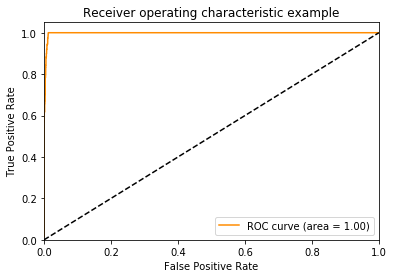

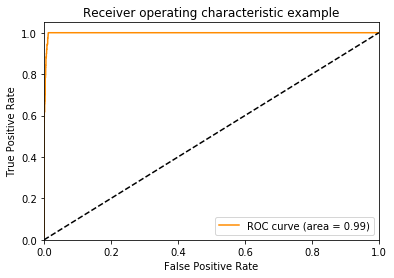

In [102]:
fpr, tpr, _ = roc_curve(intent_bin,proba_bin)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

fpr2, tpr2, _ = roc_curve(intent_bin2,proba_bin2)
roc_auc2 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

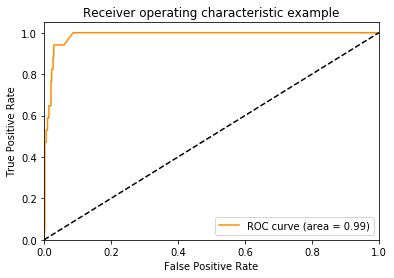

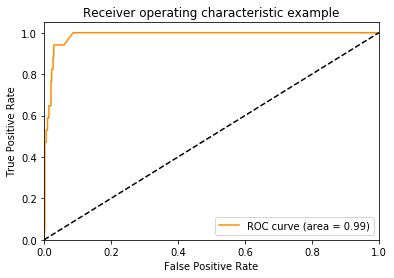

In [110]:
probaClasses = cla.predict_proba(Xv)
intent_bin=np.array(data_valid_clean1['Intent']=='#6-49_TRTEINS_Peau')*1.0
proba_bin=probaClasses[:,np.where(cla.classes_=='#6-49_TRTEINS_Peau')[0][0]] #sur chq ligne une question prédire : les probas d'appartenance à chaque classe

intent_bin2=np.array(data_valid_clean1['Intent']=='#6-97_TRTEINS_Nausees_Vomissements')*1.0
proba_bin2=probaClasses[:,np.where(cla.classes_=='#6-97_TRTEINS_Nausees_Vomissements')[0][0]] #sur chq ligne une question prédire : les probas d'appartenance à chaque classe

fpr, tpr, _ = roc_curve(intent_bin,proba_bin)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

fpr2, tpr2, _ = roc_curve(intent_bin2,proba_bin2)
roc_auc2 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### courbes pour une petite categ

In [57]:
intent_bin=np.array(data_train_clean1['Intent']=='#2-115_QVDP_Grossesse_Allaitement')*1.0
proba_bin=probaClasses[:,np.where(cla.classes_=='#2-115_QVDP_Grossesse_Allaitement')[0][0]] #sur chq ligne une question prédire : les probas d'appartenance à chaque classe
fpr, tpr, _ = roc_curve(intent_bin,proba_bin)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [4511, 502]

# meta classes

In [58]:
#meta classe
categories = data_train_clean1['Intent']
tailleCat = int(np.shape(categories)[0])
LabelCat = np.zeros(tailleCat)
for k in range(tailleCat):
    # la categorie #0 a le label 0 implicitement
    if categories[k][0:2]=='Pr':  LabelCat[k] = 11#profile
    if (categories[k][0:2] == 'co' or categories[k][0:2]=='Co'): LabelCat[k] = 10 #conversation_rappel_rendezvous
    if categories[k][0:2] == '#1' : LabelCat[k] = 1
    if categories[k][0:2] == '#2' : LabelCat[k] = 2
    if categories[k][0:2] == '#5' : LabelCat[k] = 5
    if categories[k][0:2] == '#6' : LabelCat[k] = 6
    if categories[k][0:2] == '#7' : LabelCat[k] = 7
    if categories[k][0:2] == '#8' : LabelCat[k] = 8
    if categories[k][0:2] == '#9' : LabelCat[k] = 9
        
#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat = pd.DataFrame(LabelCat)
meta_df = pd.concat([data_train_clean1, dfLabelCat], axis=1)


categories_v = data_valid_clean1['Intent']
tailleCat_v = int(np.shape(categories_v)[0])
LabelCat_v = np.zeros(tailleCat_v)
for k in range(tailleCat_v):
    # la categorie #0 a le label 0 implicitement
    if categories_v[k][0:2]=='Pr':  LabelCat_v[k] = 11#profile
    if (categories_v[k][0:2] == 'co' or categories_v[k][0:2]=='Co'): LabelCat_v[k] = 10 #conversation_rappel_rendezvous
    if categories_v[k][0:2] == '#1' : LabelCat_v[k] = 1
    if categories_v[k][0:2] == '#2' : LabelCat_v[k] = 2
    if categories_v[k][0:2] == '#5' : LabelCat_v[k] = 5
    if categories_v[k][0:2] == '#6' : LabelCat_v[k] = 6
    if categories_v[k][0:2] == '#7' : LabelCat_v[k] = 7
    if categories_v[k][0:2] == '#8' : LabelCat_v[k] = 8
    if categories_v[k][0:2] == '#9' : LabelCat_v[k] = 9
        
#data frame avec une colonne mettant un label suivant la meta categorie
dfLabelCat_v = pd.DataFrame(LabelCat_v)
meta_df_v = pd.concat([data_valid_clean1, dfLabelCat_v], axis=1)


In [59]:
vec,X_m = vectorizer_train(meta_df,"Question")
Y_m = meta_df[0].values #les étiquettes : les catégories
Xv_m = apply_vectorizer(meta_df_v,vec,"Question")
Yv_m = meta_df_v[0].values

In [73]:
cla_meta = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1, fit_intercept=True,
                          intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear',
                          max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
cla_meta.fit(X_m,Y_m)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
training_score=cla_meta.score(X_m,Y_m)
print "training score = "
print training_score

training score = 
0.886943028153


In [75]:
v_score=cla_meta.score(Xv_m,Yv_m)
print "valid score = "
print v_score

valid score = 
0.838645418327


On obtient de meilleurs resultats que précédemment

### ci dessous les effectifs de la prédiction

In [76]:
predict_meta_v=cla_meta.predict(Xv_m)
sorted(collections.Counter(predict_meta_v).items(), key=lambda x : x[1], reverse=True)

[(6.0, 247),
 (2.0, 219),
 (9.0, 16),
 (10.0, 12),
 (11.0, 3),
 (7.0, 2),
 (0.0, 1),
 (5.0, 1),
 (8.0, 1)]

### Ci dessous les effectifs reels

In [78]:
sorted(collections.Counter(meta_df_v[0]).items(), key=lambda x : x[1], reverse=True)

[(6.0, 220),
 (2.0, 205),
 (9.0, 20),
 (10.0, 16),
 (1.0, 12),
 (7.0, 7),
 (0.0, 6),
 (5.0, 6),
 (11.0, 6),
 (8.0, 4)]

pareil qu'avant il en a mis trop dans les catégories à gros effectifs et pas assez dans les petites categ

## Roc curves pour toutes les meta

In [79]:
probaClasses_meta=cla_meta.predict_proba(Xv_m)
print probaClasses_meta

[[ 0.01735709  0.19798143  0.11076512 ...,  0.04497886  0.01817437
   0.35210654]
 [ 0.01086867  0.01464354  0.30056049 ...,  0.02126862  0.01293759
   0.00671075]
 [ 0.00933306  0.01146627  0.04740432 ...,  0.01627922  0.71535178
   0.00597683]
 ..., 
 [ 0.00504602  0.00606618  0.22018455 ...,  0.00423605  0.00554956
   0.00376847]
 [ 0.00892542  0.00850718  0.16382128 ...,  0.01258759  0.01031484
   0.00575498]
 [ 0.0095586   0.00940984  0.83121965 ...,  0.01500213  0.01107646
   0.00609554]]


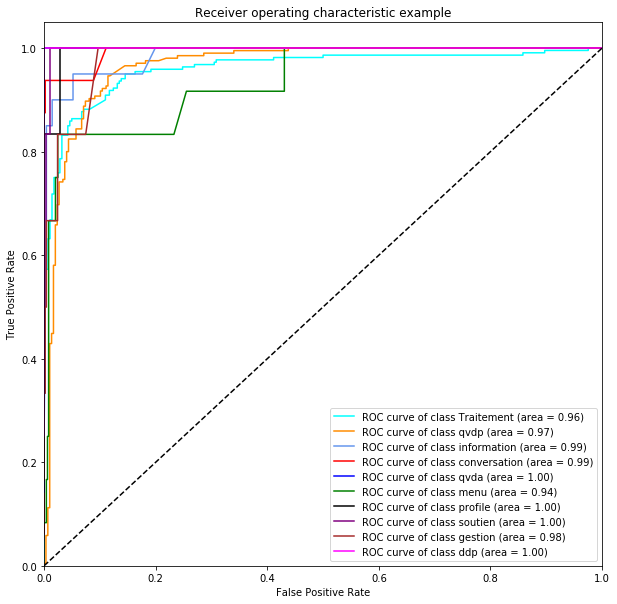

In [81]:
l=[6.0,2.0,9.0,10.0,7.0,1.0,11.0,5.0,0.0,8.0]
l1=["Traitement","qvdp","information","conversation","qvda","menu","profile","soutien","gestion","ddp"]
intent_bin=[]
proba_bin=[]
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(0,10,1):
    intent_bin.append(np.array(meta_df_v[0]==l[i])*1.0)
    proba_bin.append(probaClasses_meta[:,np.where(cla_meta.classes_==l[i])[0][0]])
    fpr[i], tpr[i], _ = roc_curve(intent_bin[i],proba_bin[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,10))
colors=(['aqua','darkorange','cornflowerblue','red','blue','green','black','purple','brown','magenta'])
for i, color in zip(range(10),colors):
    plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of class {0} (area = {1:0.2f})' ''.format(l1[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


la categ 6 est aqua
la plus mauvaise : verte : une categ a faible effectif
la meilleure : magenta : une categ a faible efffectif aussi 